In [ ]:
%matplotlib inline
!pip install plotly
!pip install yahoo_fin
import pandas as pd
import numpy as np
import seaborn as sns # !
import matplotlib.pyplot as plt # !
from matplotlib.colors import ListedColormap
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import HTML
import plotly.express as px
from yahoo_fin.stock_info import get_data
from google.colab import drive
import requests
from datetime import datetime, date, timedelta

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from keras.optimizers import gradient_descent_v2 #SGD
import math
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

sgd = gradient_descent_v2.SGD(...)

mergers = pd.read_csv('https://raw.githubusercontent.com/vladgrish/ds_spac_project/gh-pages/merger_spacs.csv')
pending_mergers =  pd.read_csv('https://raw.githubusercontent.com/vladgrish/ds_spac_project/gh-pages/pending_spac_mergers.csv')

# some additional settings for sns
sns.set()
sns.set(rc={"figure.figsize": (20, 10)})
PALETTE = sns.color_palette('deep', n_colors=3) # will be used for cmap which is a parameter of seaborn scatter
CMAP = ListedColormap(PALETTE.as_hex()) # A Colormap instance or registered colormap name. cmap is only used if c is an array of floats.
RANDOM_STATE = 42

reading the prepared datasets into a dictionary

In [2]:

# reading all datasets with additional metrics from github (1 minute comparing to 8 when using yahoo api, gdrive is no better...)
# this is the final section for getting the data
def get_symbol_data(ticker):
  df = pd.read_csv(f'https://raw.githubusercontent.com/vladgrish/ds_spac_project/gh-pages/stock_csv_data/{ticker}.csv', index_col=0)[1:]
  df.index = pd.to_datetime(df.index)
  return df

merged_symbols = mergers['Symbol'].values.tolist()
pending_mergers_symbols = pending_mergers['Symbol'].values.tolist()

if 'dfs' not in globals():# or True:
  dfs = {}
  for x in merged_symbols+pending_mergers_symbols:
     dfs[x] = {}
     dfs[x]['data'] = get_symbol_data(x)

selecting the feature set and normalazing it
the feature list and label list also defines the input and output shape of the model

In [146]:
# scale all features
# feature_cols = ['close', 'volume', 'nasdaq_pct_change', 'low/high', 'daily_pct_change', 'close_pct_change', 'pre_market_pct_change', 'nasdaq/stock_pct_change']
feature_cols = ['close']
label_col = 'close'
for x in merged_symbols:
  df = dfs[x]['data'].copy()
  dfs[x]['scaler'] = MinMaxScaler(feature_range=(0,1))
  df[feature_cols] = dfs[x]['scaler'].fit_transform(df[feature_cols])
  # df[feature_cols] = dfs[x]['scaler'].transform(df[feature_cols])
  dfs[x]['scaled'] = df[feature_cols].copy()

splitting the data set aroung the price peak of each SPAC stock, the idea behind it is prevent the model from learning off of data where the stock price barely changes

In [147]:
# split the data around the price peak
from operator import index
for x in merged_symbols:
  df = dfs[x]['scaled']
  dfs[x]['max_price_date'] = df['close'].idxmax()
  dfs[x]['max_price'] = df['close'].max()
  try:
    dfs[x]['train'] = df[dfs[x]['max_price_date']-timedelta(days=40):dfs[x]['max_price_date']+timedelta(days=40)].copy()
  except:
    dfs[x]['train'] = df.copy()

here's an example of what the SPAC stock looks like when price peaks

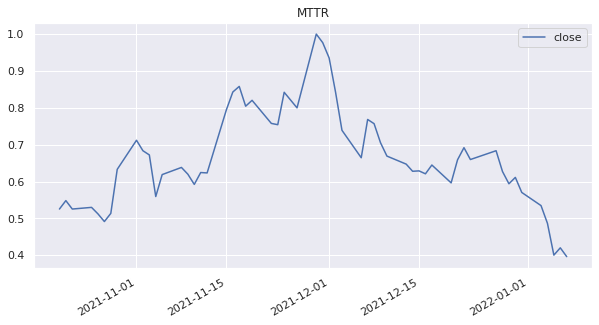

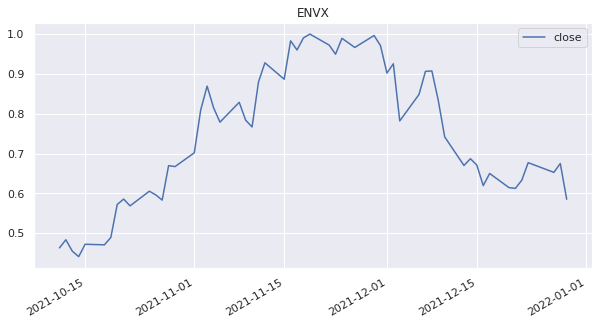

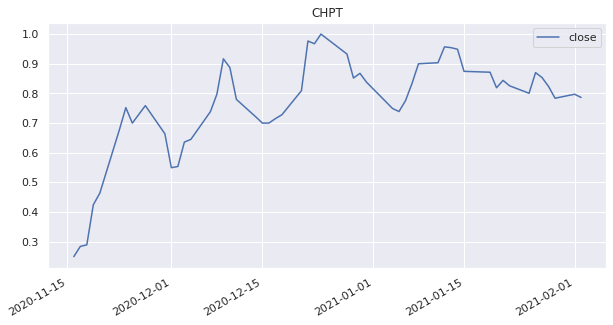

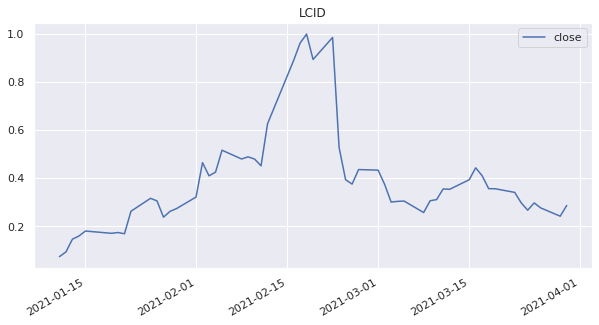

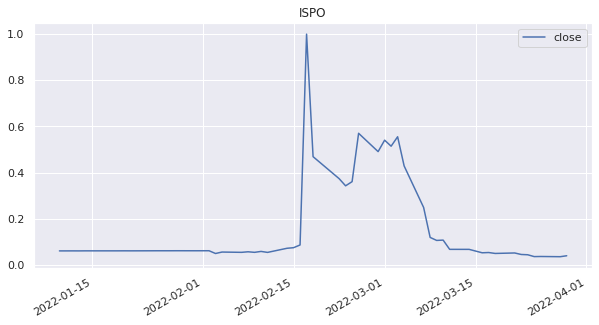

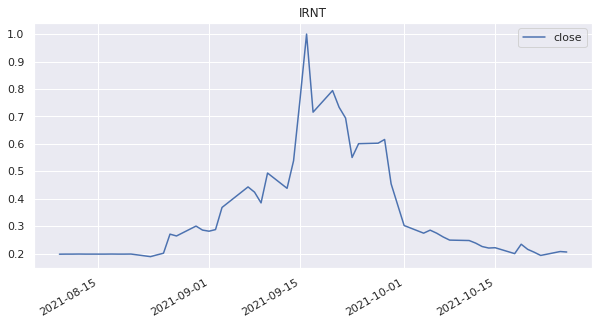

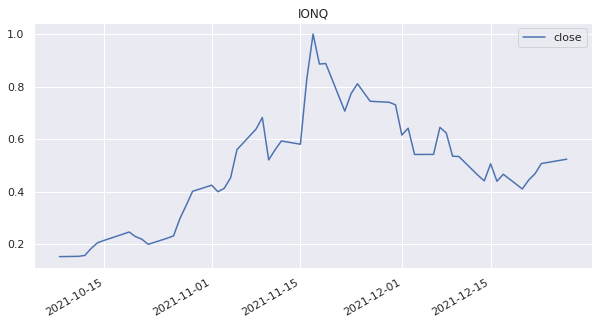

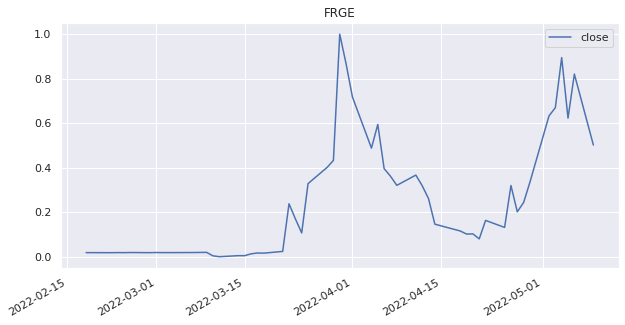

In [163]:
for x in ['MTTR', 'ENVX', 'CHPT', 'LCID', 'ISPO', 'IRNT', 'IONQ', 'FRGE']: #merged_symbols[:50]:
  ax = dfs[x]['train'][['close']].plot(figsize=(10,5), title=x)
  plt.show()

Each time we will feed the model X obseravation days and predict Y days
Current setup is 30 days input, 1 day output

In [149]:
observed_period = 30
# predicted_period = 4
# prepeare input/output vectors
for x in merged_symbols:
  df = dfs[x]['train'].copy()
  daily_data = df[feature_cols].values # element per day
  train_features, labels = [], []
  for i in range(observed_period, df.index.size):
    train_features.append(daily_data[i-observed_period:i, :]) # x days, all features
    labels.append(daily_data[i, :]) # x output days labels

  dfs[x]['train_features'], dfs[x]['labels'] = np.array(train_features), np.array(labels)
  print(f'{x} shapes:')
  print("\ttrain input shape: ", dfs[x]['train_features'].shape)
  print("\ttrain output shape", dfs[x]['labels'].shape)

EVEX shapes:
	train input shape:  (0,)
	train output shape (0,)
SAI shapes:
	train input shape:  (25, 30, 1)
	train output shape (25, 1)
SMR shapes:
	train input shape:  (26, 30, 1)
	train output shape (26, 1)
SOUN shapes:
	train input shape:  (0,)
	train output shape (0,)
MLTX shapes:
	train input shape:  (26, 30, 1)
	train output shape (26, 1)
LLAP shapes:
	train input shape:  (26, 30, 1)
	train output shape (26, 1)
FRGE shapes:
	train input shape:  (25, 30, 1)
	train output shape (25, 1)
DRTS shapes:
	train input shape:  (25, 30, 1)
	train output shape (25, 1)
RGTI shapes:
	train input shape:  (25, 30, 1)
	train output shape (25, 1)
QTEK shapes:
	train input shape:  (9, 30, 1)
	train output shape (9, 1)
CPTN shapes:
	train input shape:  (25, 30, 1)
	train output shape (25, 1)
ISPO shapes:
	train input shape:  (25, 30, 1)
	train output shape (25, 1)
NRGV shapes:
	train input shape:  (26, 30, 1)
	train output shape (26, 1)
QNGY shapes:
	train input shape:  (25, 30, 1)
	train output sh

For plotting and validation we used the same data as for training but for better visualization we cut it 3 days after the price peak.

We drop some of the stocks that don't have enough data

In [151]:
# split the data around the price peak
c = []
from operator import index
for x in merged_symbols:
  df = dfs[x]['scaled'].copy()
  df = df[:dfs[x]['max_price_date']+timedelta(days=3)]
  print(x, df.index.size)
  if not df.index.size < observed_period:
    dfs[x]['test'] = df.copy()
    test_data = df[feature_cols].values
    # print(test_data.shape)
    # break
    test_features = []
    for i in range(observed_period, df.index.size):
      test_features.append(test_data[i-observed_period:i, :]) # x days, all features
    dfs[x]['test_features'] = np.asarray(test_features)
    print(f'{x} shapes:')
    print("\ttest input shape: ", dfs[x]['test_features'].shape)
  else:
    c.append(x)
    dfs[x]['test'] = None
    dfs[x]['test_features'] = None
print(c)

EVEX 17
SAI 212
SAI shapes:
	test input shape:  (182, 30, 1)
SMR 32
SMR shapes:
	test input shape:  (2, 30, 1)
SOUN 6
MLTX 370
MLTX shapes:
	test input shape:  (340, 30, 1)
LLAP 236
LLAP shapes:
	test input shape:  (206, 30, 1)
FRGE 295
FRGE shapes:
	test input shape:  (265, 30, 1)
DRTS 271
DRTS shapes:
	test input shape:  (241, 30, 1)
RGTI 148
RGTI shapes:
	test input shape:  (118, 30, 1)
QTEK 12
CPTN 229
CPTN shapes:
	test input shape:  (199, 30, 1)
ISPO 260
ISPO shapes:
	test input shape:  (230, 30, 1)
NRGV 261
NRGV shapes:
	test input shape:  (231, 30, 1)
QNGY 208
QNGY shapes:
	test input shape:  (178, 30, 1)
CORZ 159
CORZ shapes:
	test input shape:  (129, 30, 1)
SKYH 322
SKYH shapes:
	test input shape:  (292, 30, 1)
SST 421
SST shapes:
	test input shape:  (391, 30, 1)
ANGH 377
ANGH shapes:
	test input shape:  (347, 30, 1)
FSRD 3
LFLY 602
LFLY shapes:
	test input shape:  (572, 30, 1)
SES 185
SES shapes:
	test input shape:  (155, 30, 1)
GRNA 265
GRNA shapes:
	test input shape:  (235

Here we define the NN architecture. we used LSTM as it allows learning from multiple samples spread accross time, as we are dealing with time series dataset, this works well for us

In [152]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras import losses

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(observed_period, len(feature_cols))))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=50))
model.add(Dropout(0.2))

model.add(Dense(len(feature_cols)))
model.compile(optimizer = 'adam',
              loss = losses.MeanSquaredError(reduction='none')
              )

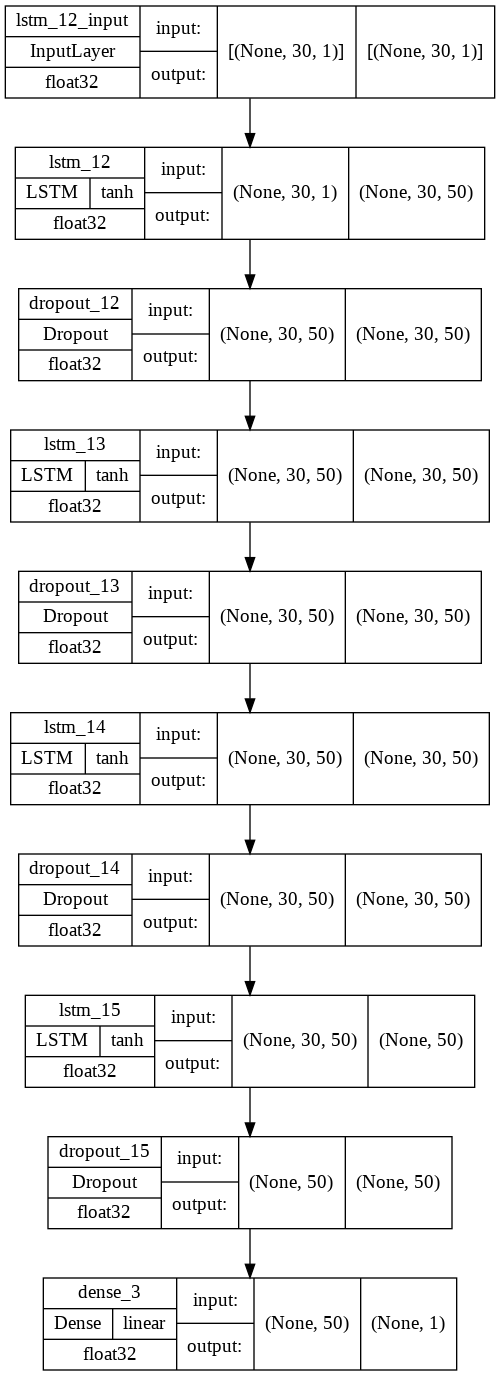

In [161]:
from keras.utils.vis_utils import plot_model
plot_model(
    model,
    show_shapes=True,
    show_dtype=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=True,
    dpi=96,
    show_layer_activations=True,
)

After the network is compiled we use every sample in out list of stocks to train it.
We feed a single network with examples of 286 of the stocks

In [154]:
drop_list = []
i = 1
for x in merged_symbols:
  if dfs[x]['train_features'].size == 0:
    drop_list.append(x)
    i+=1
  else:
    print(f"fitting {x} ({i}/{len(merged_symbols)})")
    model.fit(dfs[x]['train_features'],
              dfs[x]['labels'],
              epochs=100,
              batch_size=dfs[x]['train_features'].size,
              verbose=0)
    i+=1
print("droped: ", drop_list)

fitting SAI (2/286)
fitting SMR (3/286)
fitting MLTX (5/286)
fitting LLAP (6/286)
fitting FRGE (7/286)
fitting DRTS (8/286)
fitting RGTI (9/286)
fitting QTEK (10/286)
fitting CPTN (11/286)
fitting ISPO (12/286)
fitting NRGV (13/286)
fitting QNGY (14/286)
fitting CORZ (15/286)
fitting SKYH (16/286)
fitting SST (17/286)
fitting ANGH (18/286)
fitting LFLY (20/286)
fitting SES (21/286)
fitting GRNA (22/286)
fitting SATL (23/286)
fitting SOND (24/286)
fitting GLS (25/286)
fitting REVB (26/286)
fitting DAVE (27/286)
fitting VORB (28/286)
fitting HLGN (29/286)
fitting CMPO (30/286)
fitting ADSE (31/286)
fitting ADTH (32/286)
fitting FATH (33/286)
fitting PRDS (34/286)
fitting HYPR (35/286)
fitting CVT (36/286)
fitting EQRX (37/286)
fitting BOWL (38/286)
fitting AMPS (39/286)
fitting BOXD (40/286)
fitting SLDP (41/286)
fitting BBAI (42/286)
fitting PL (43/286)
fitting VCSA (44/286)
fitting BZFD (45/286)
fitting PIII (47/286)
fitting HGTY (48/286)
fitting CTV (49/286)
fitting LOCL (50/286)
fitt

Here we look at the test data (cut off 3 days after max price)

We take 20 days sample from 20 days ago (-37 to -17 days before max price)

each time we predict one day, append it to the input, and drop one day off the end. 

then we feed the result back to the network for 20 iterations

the results are plotted bellow

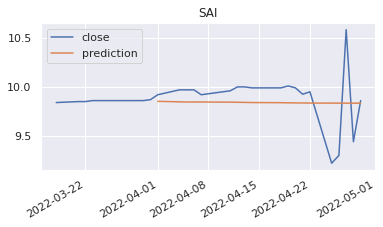

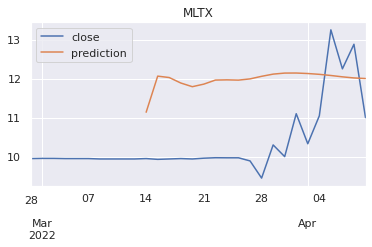

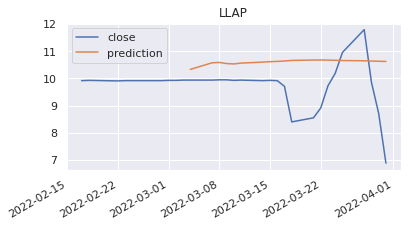

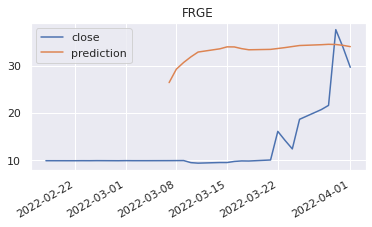

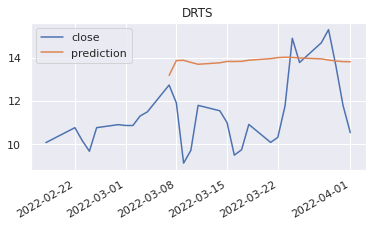

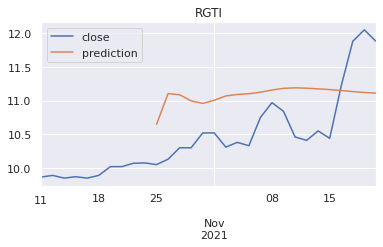

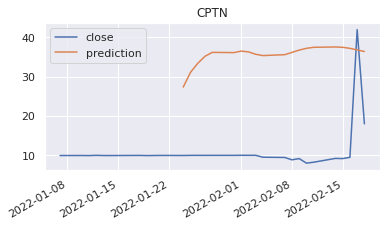

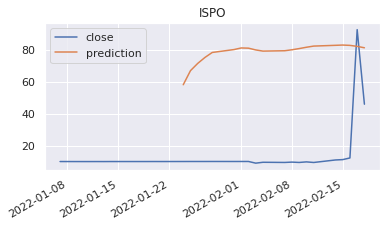

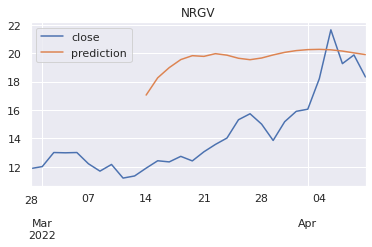

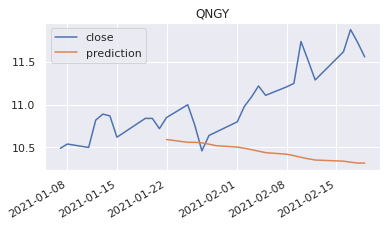

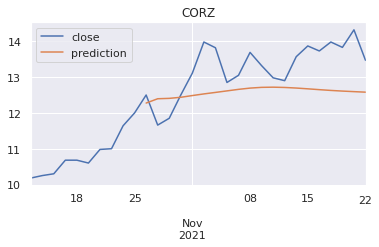

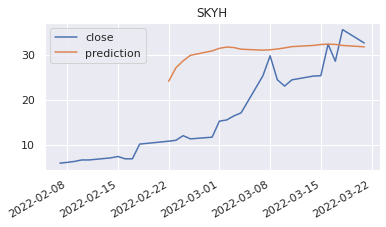

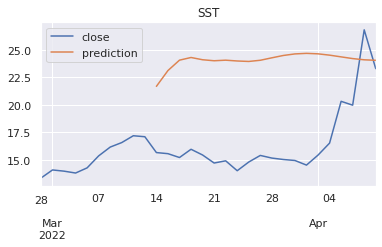

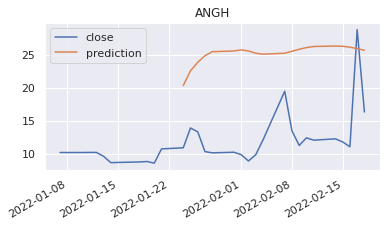

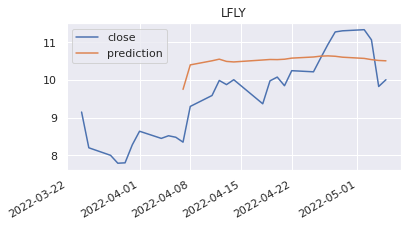

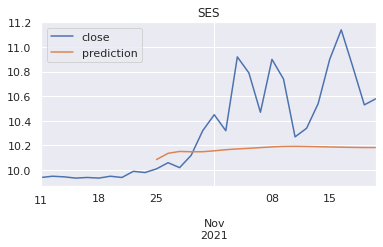

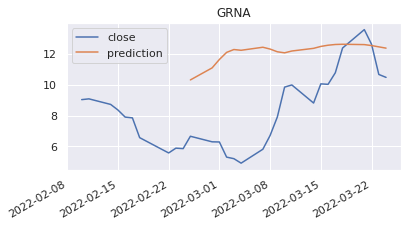

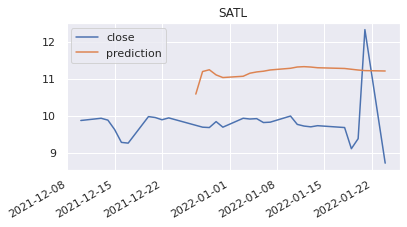

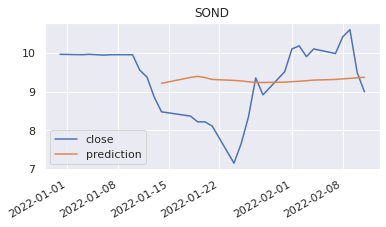

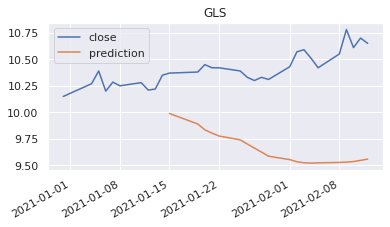

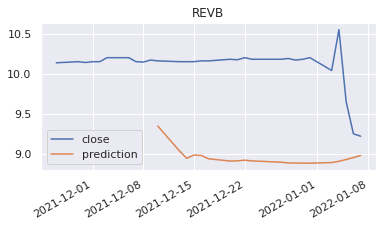

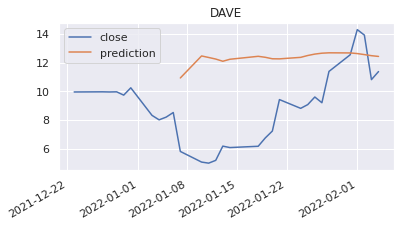

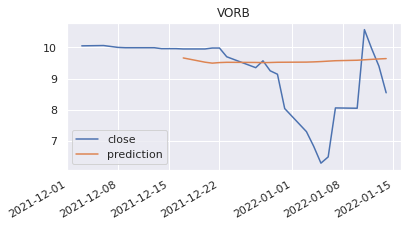

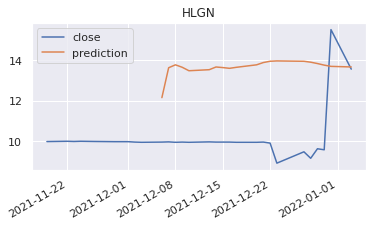

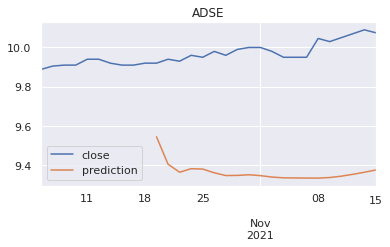

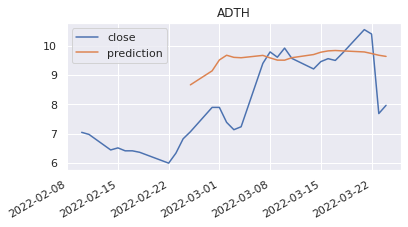

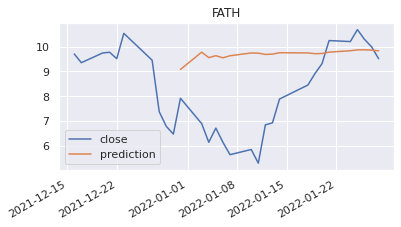

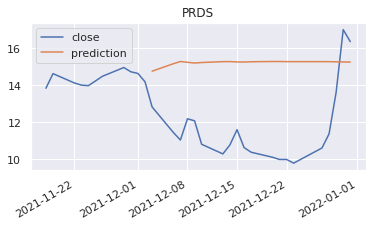

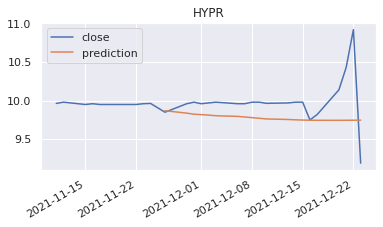

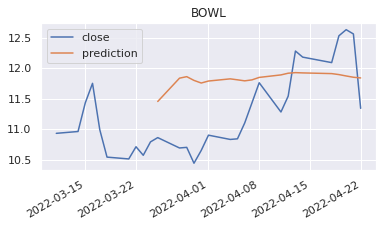

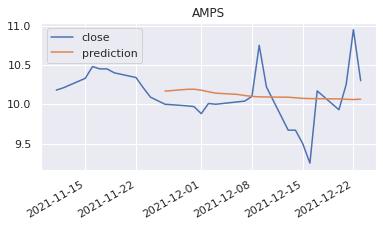

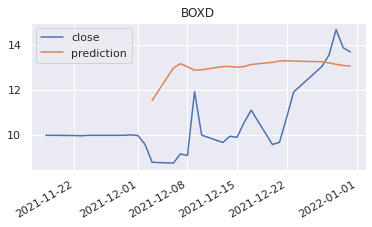

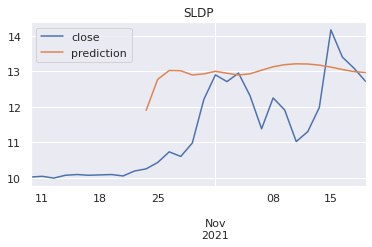

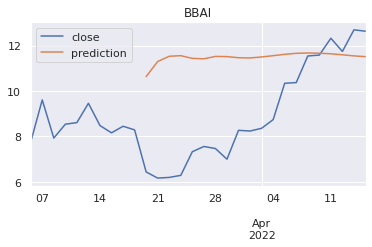

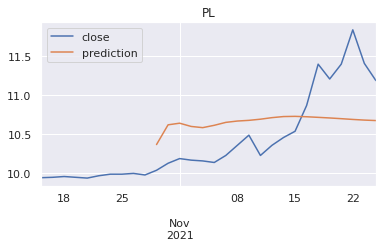

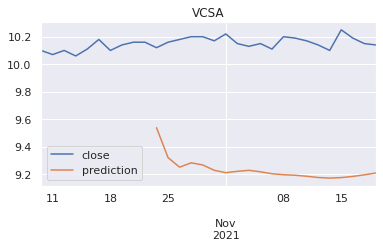

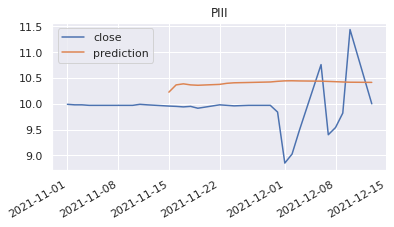

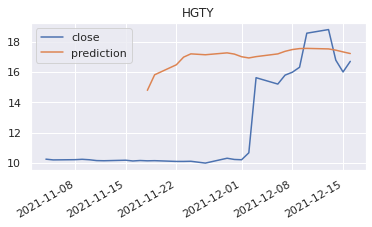

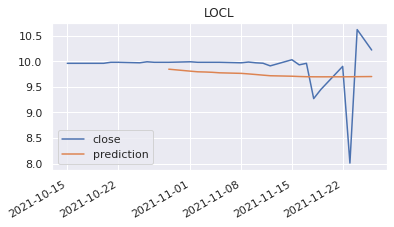

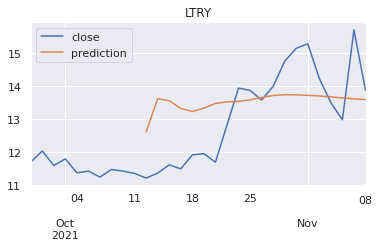

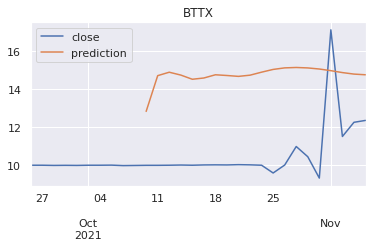

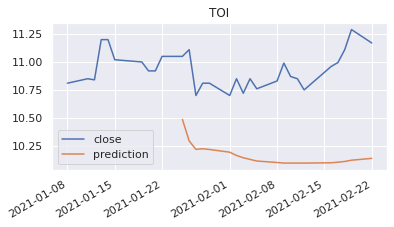

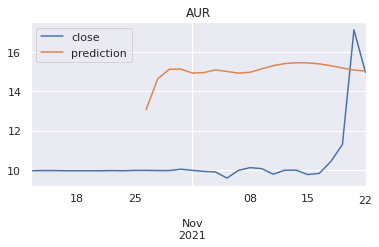

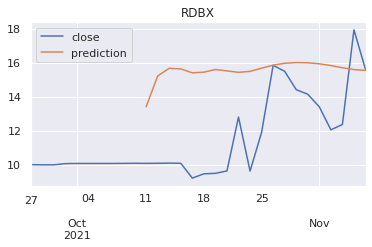

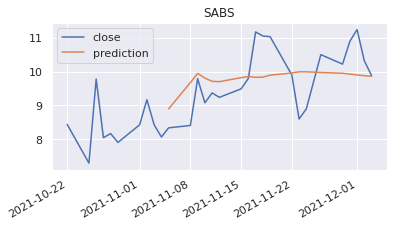

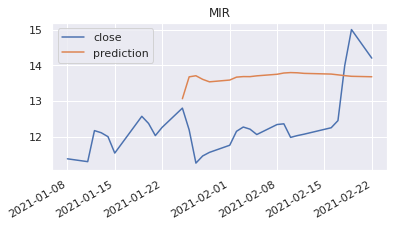

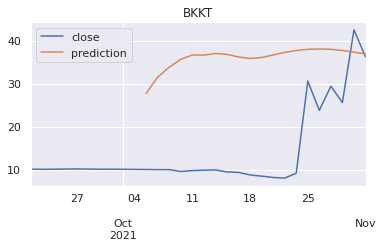

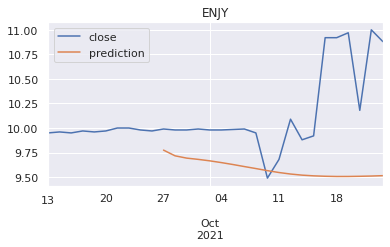

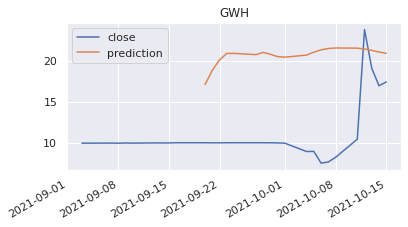

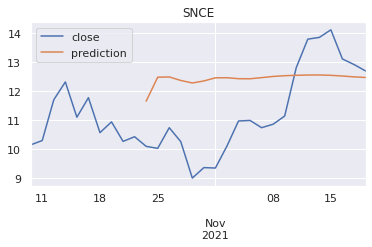

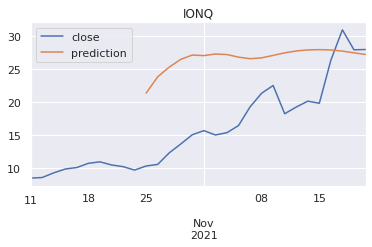

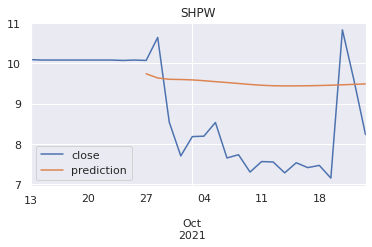

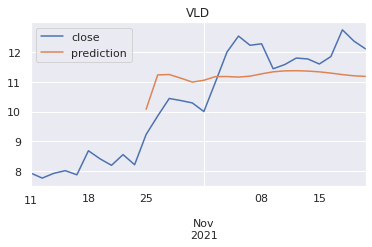

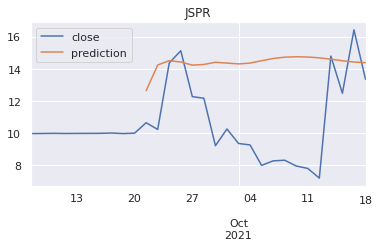

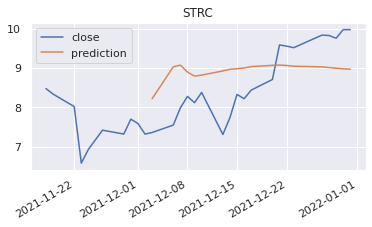

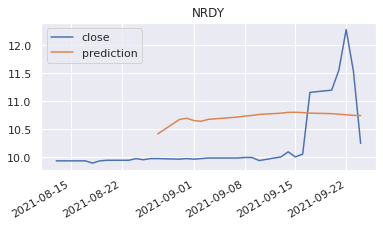

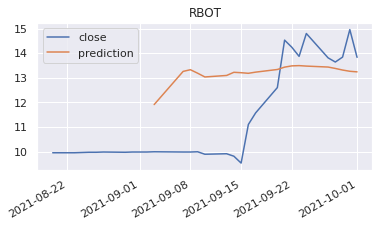

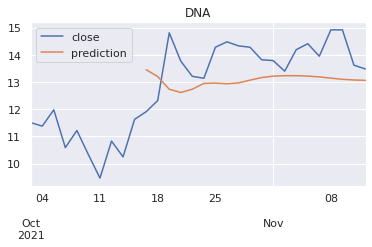

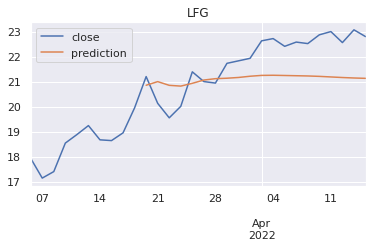

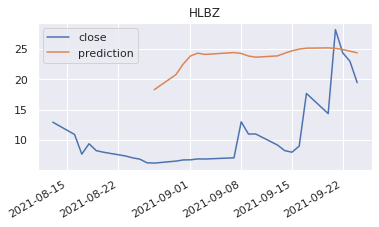

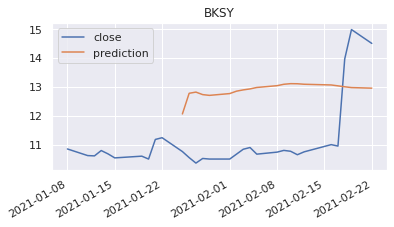

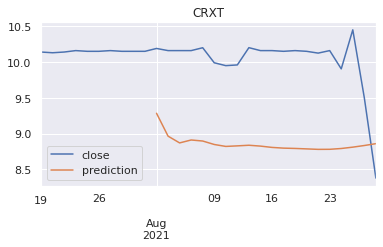

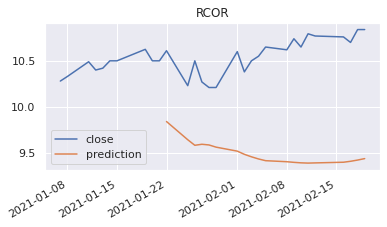

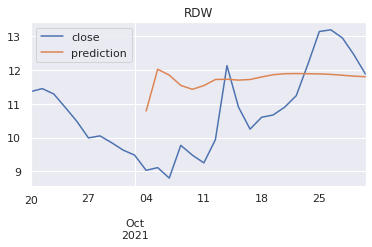

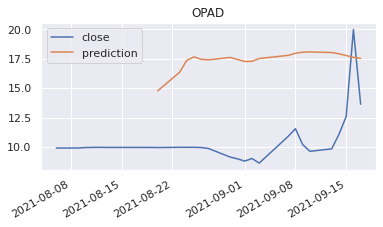

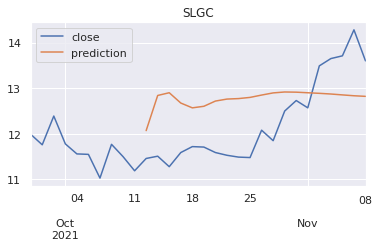

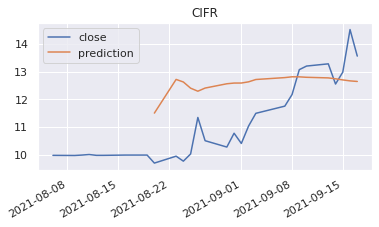

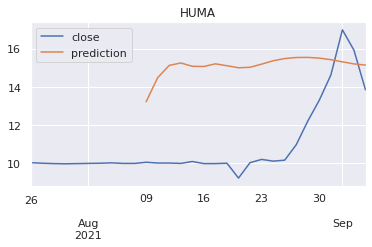

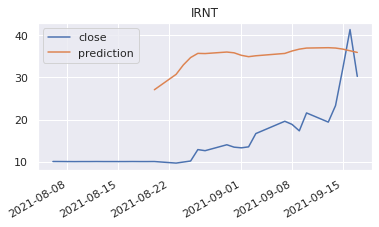

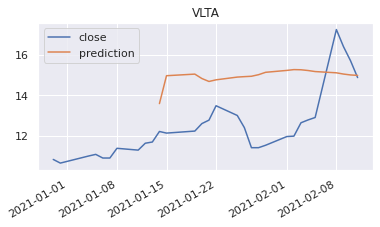

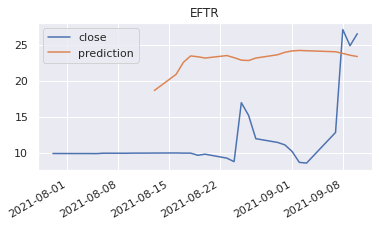

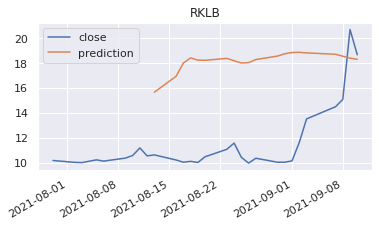

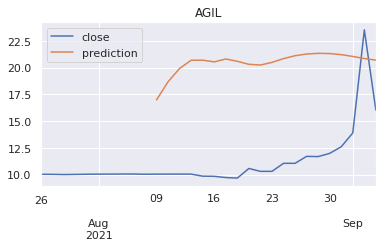

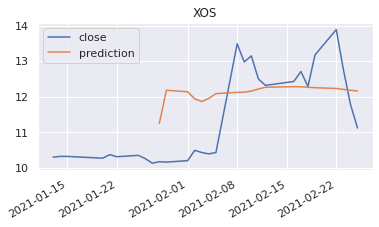

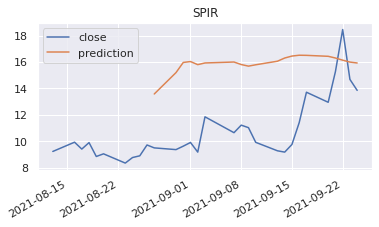

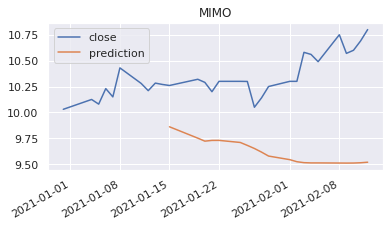

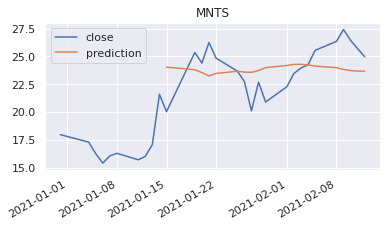

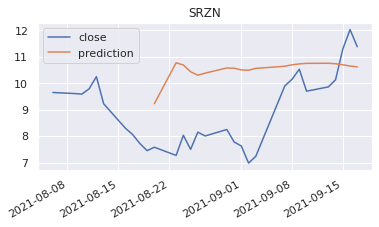

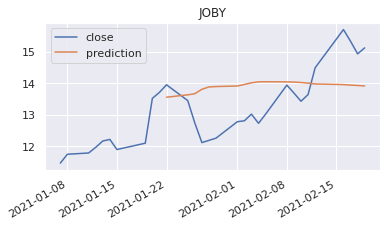

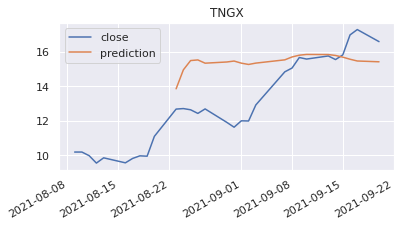

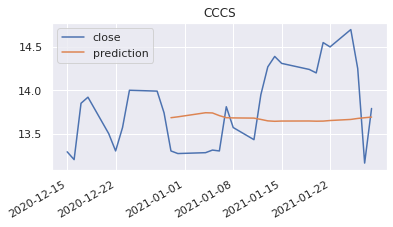

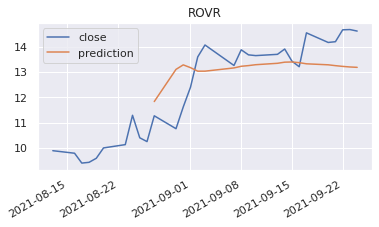

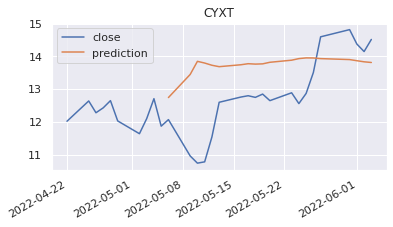

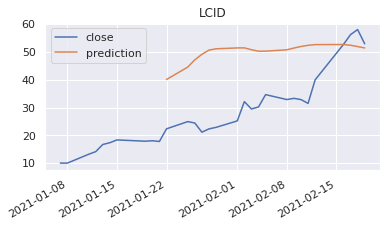

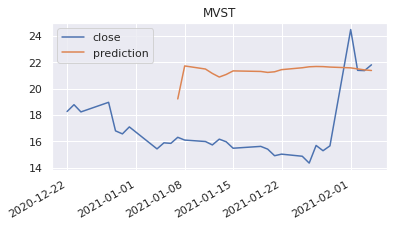

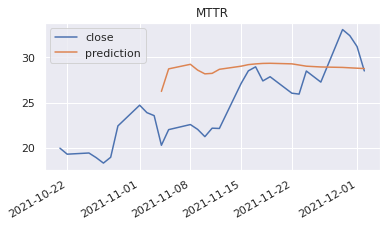

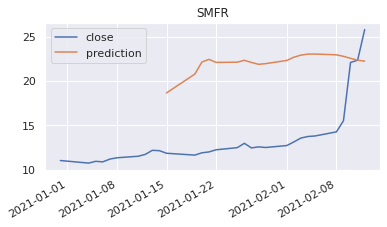

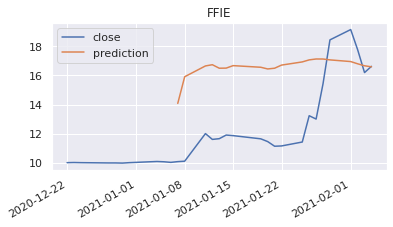

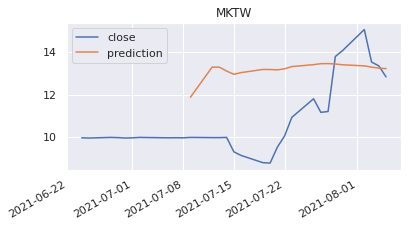

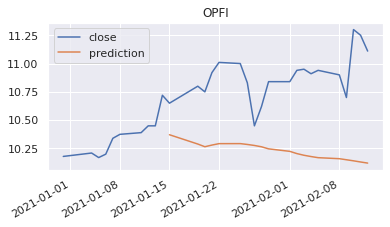

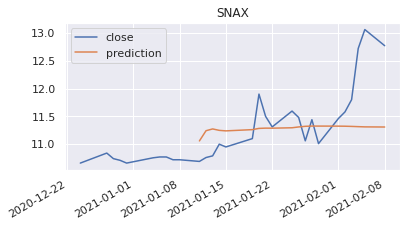

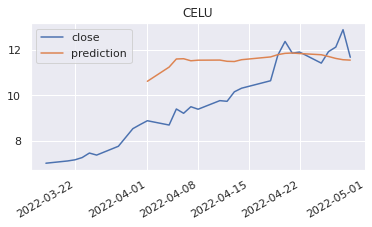

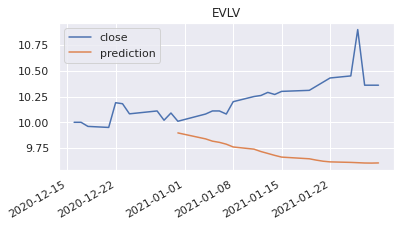

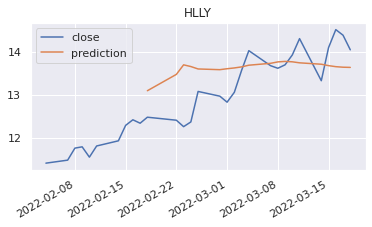

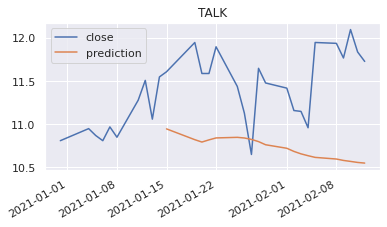

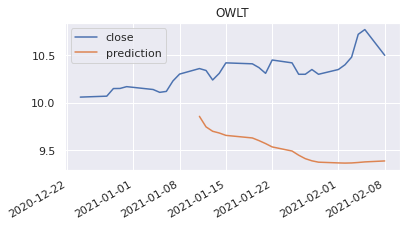

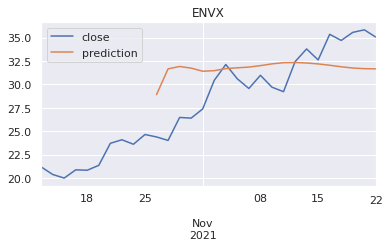

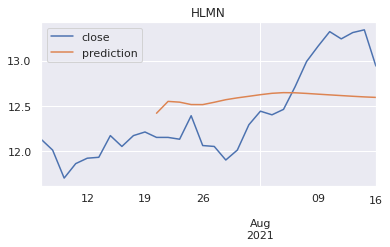

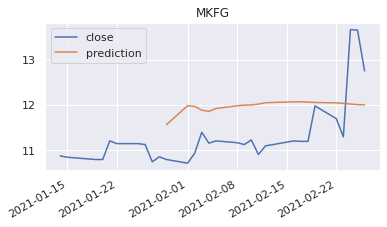

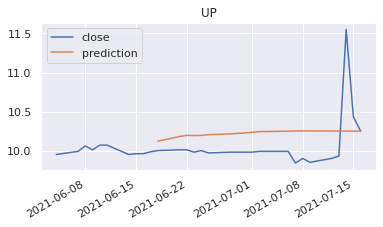

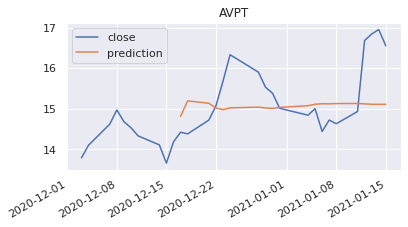

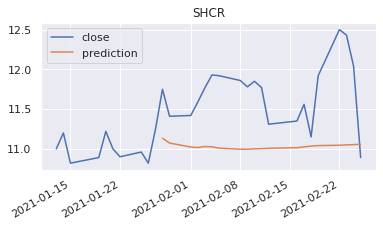

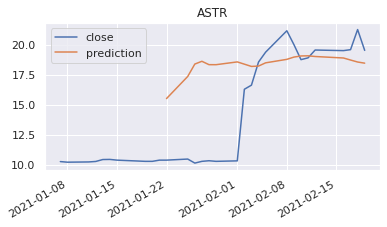

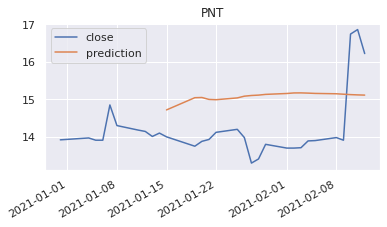

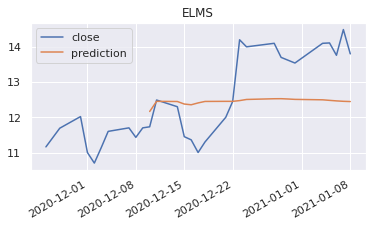

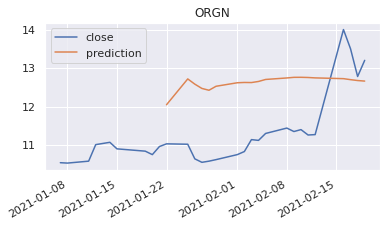

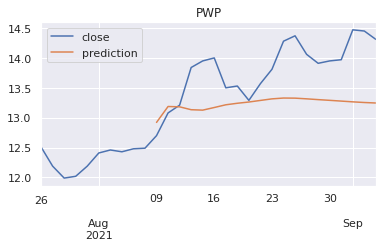

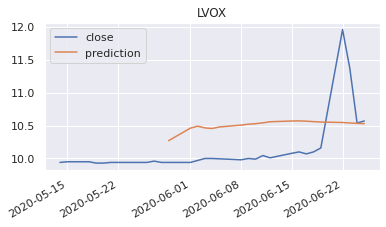

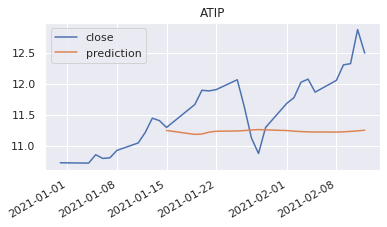

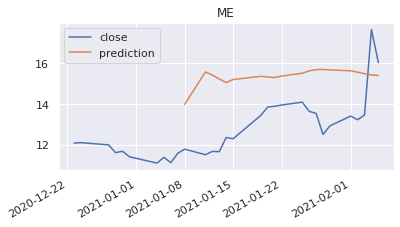

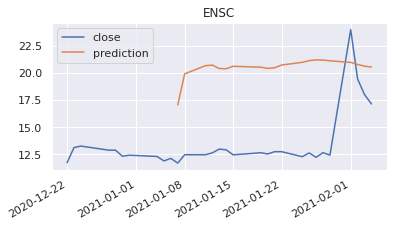

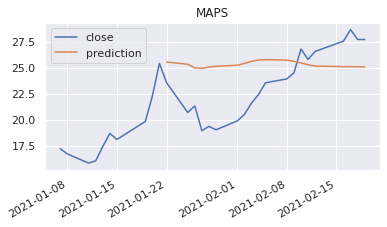

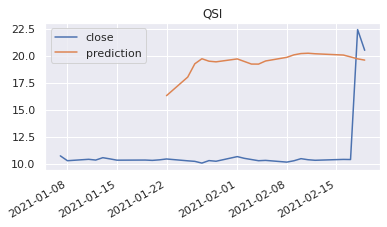

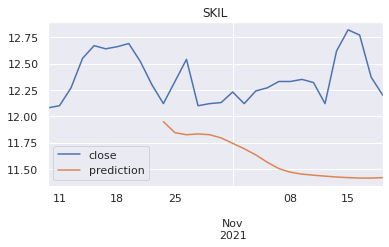

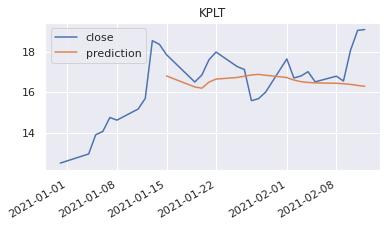

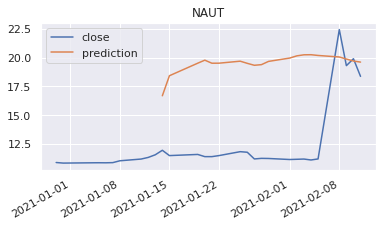

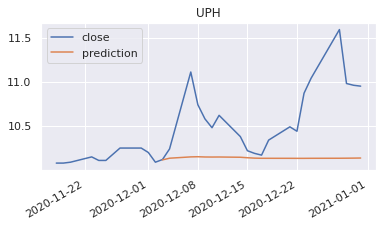

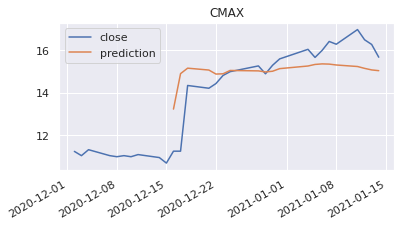

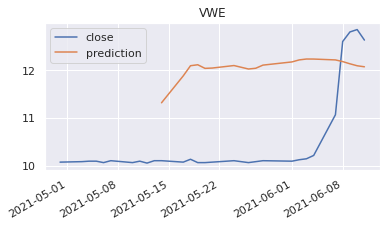

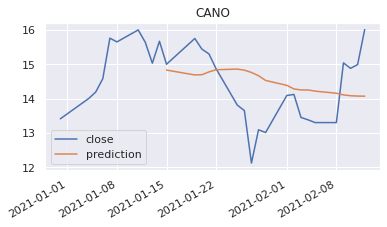

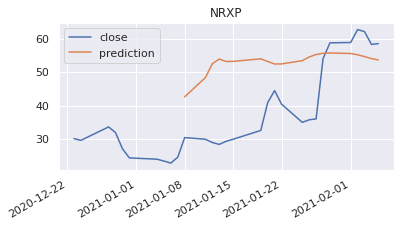

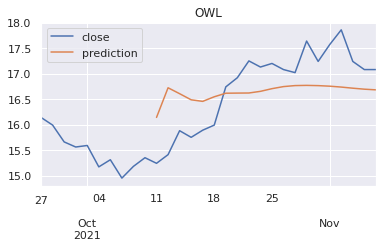

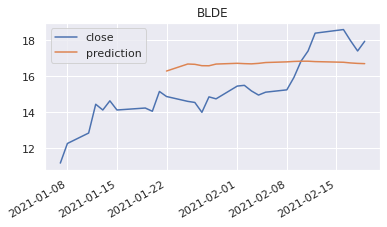

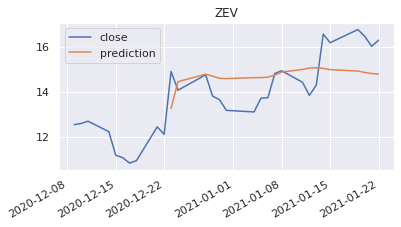

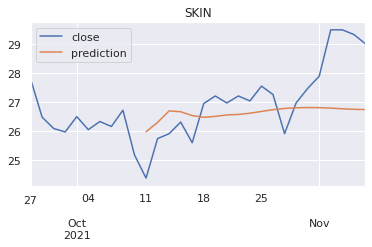

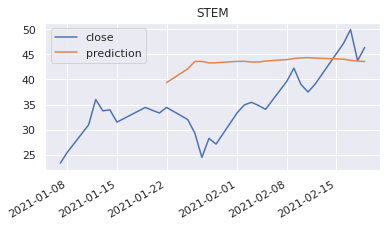

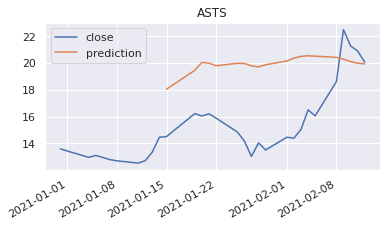

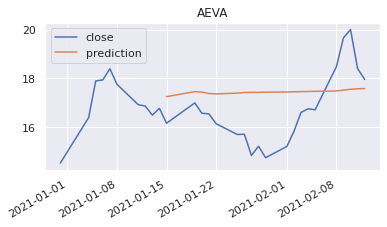

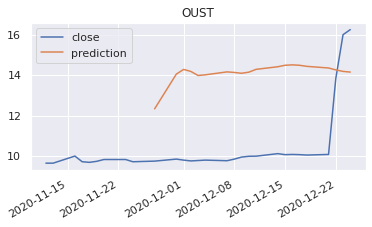

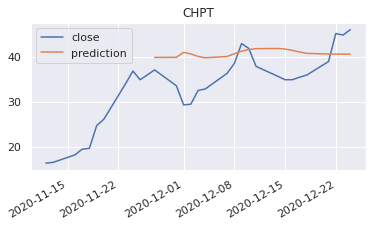

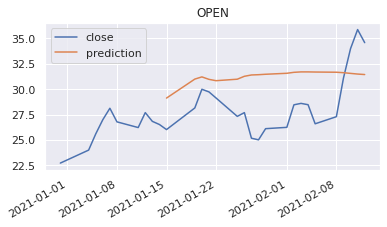

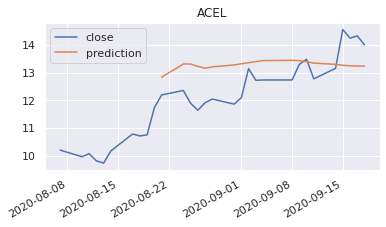

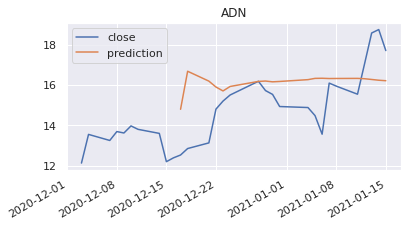

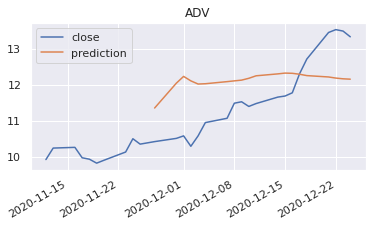

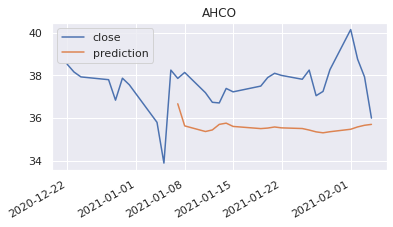

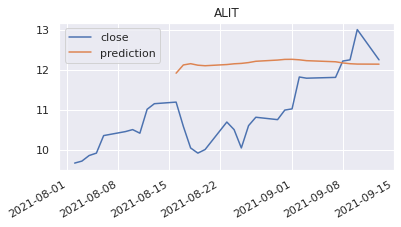

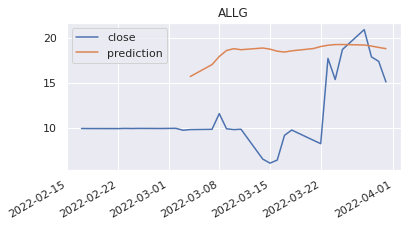

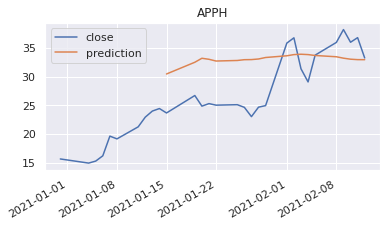

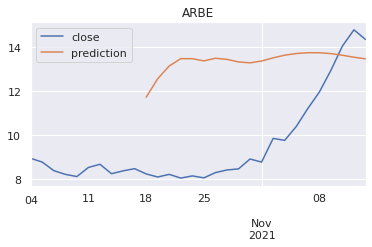

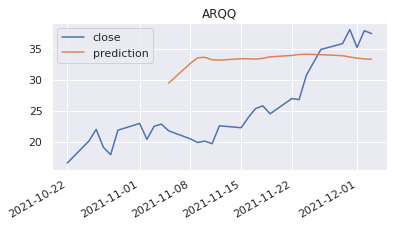

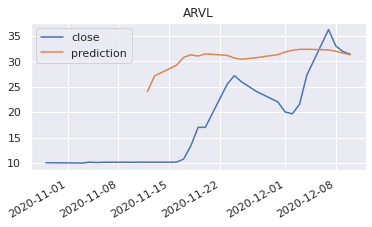

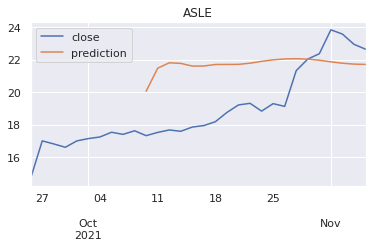

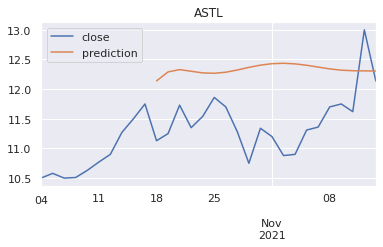

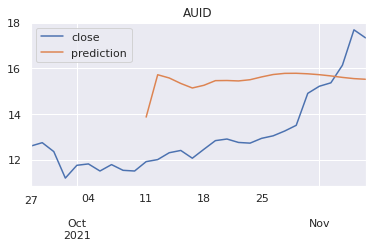

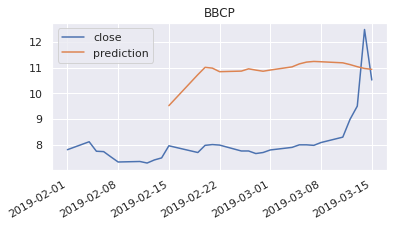

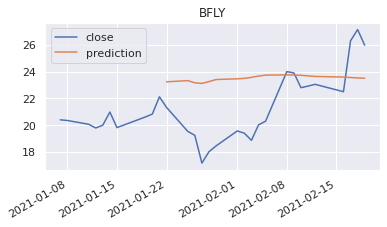

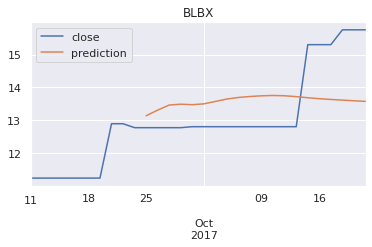

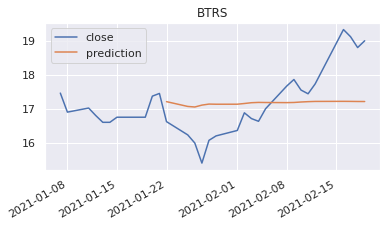

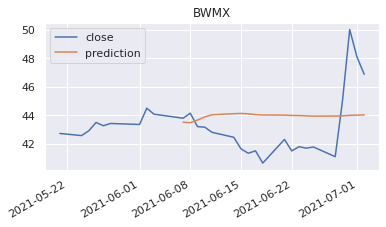

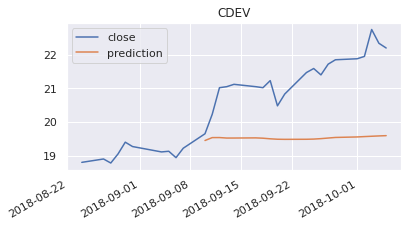

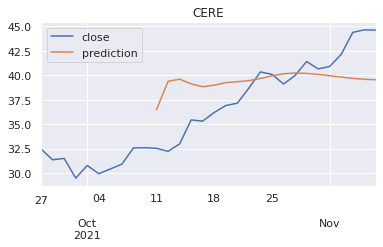

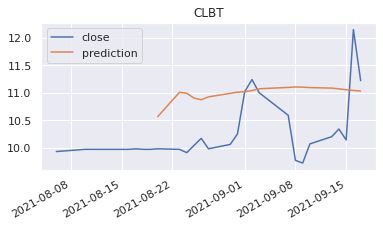

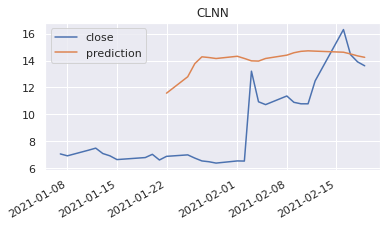

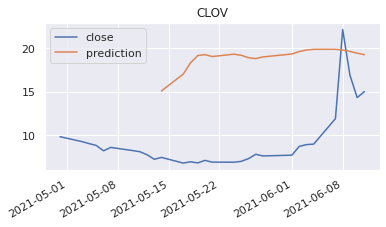

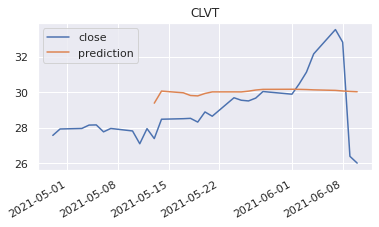

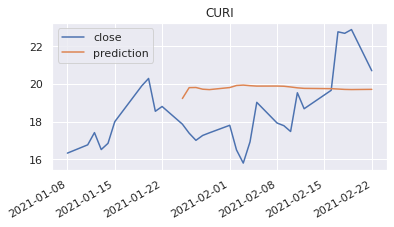

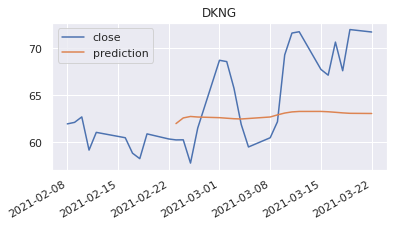

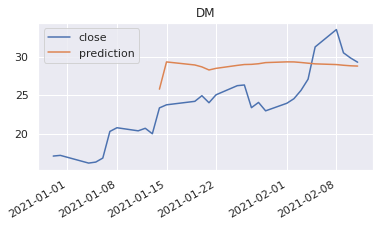

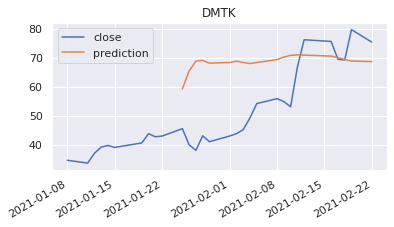

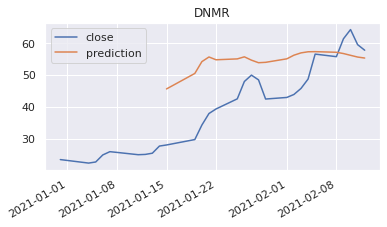

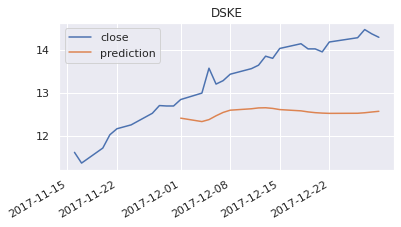

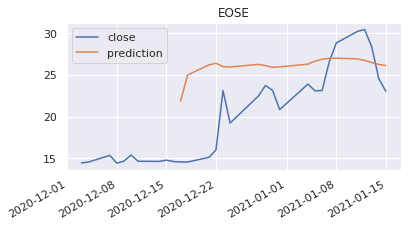

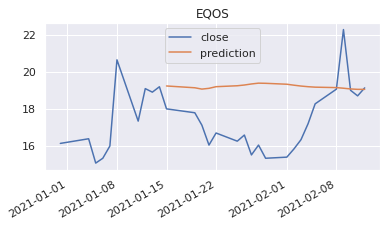

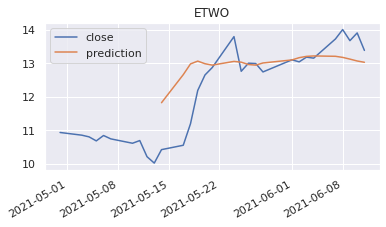

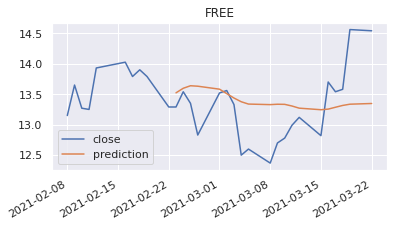

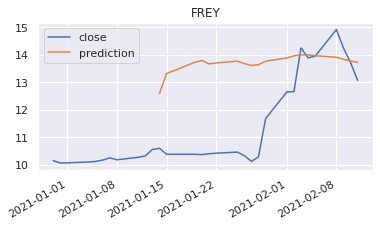

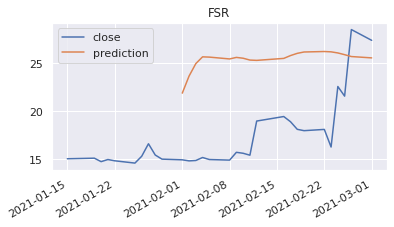

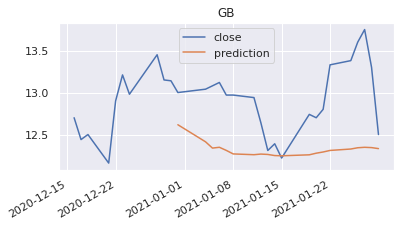

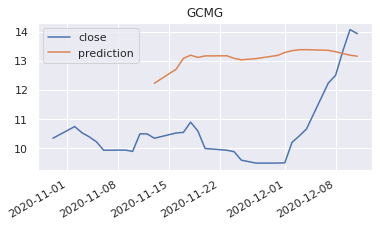

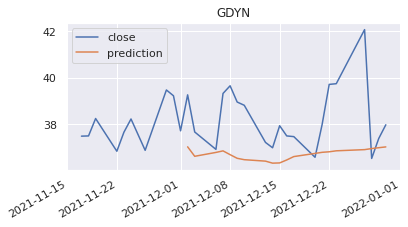

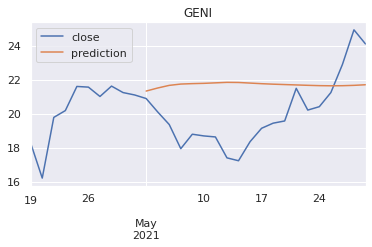

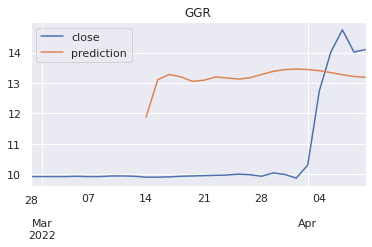

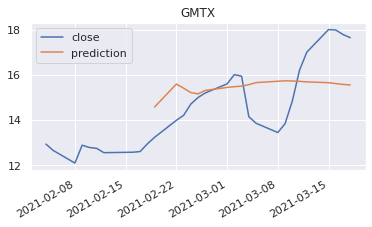

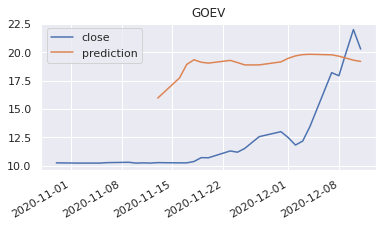

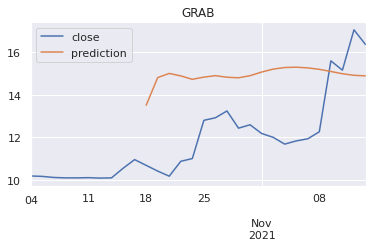

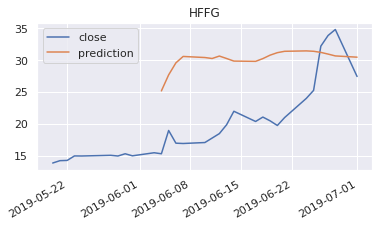

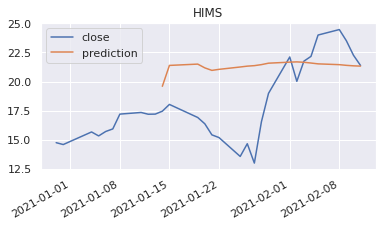

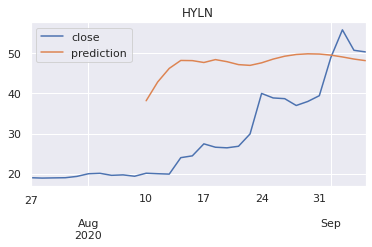

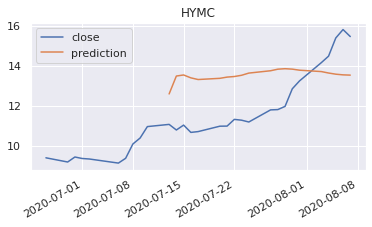

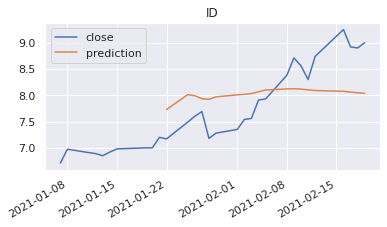

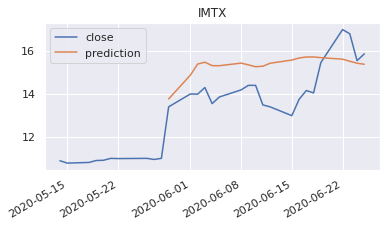

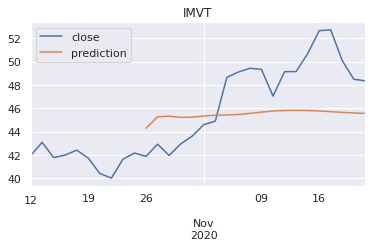

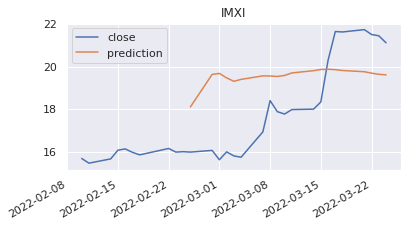

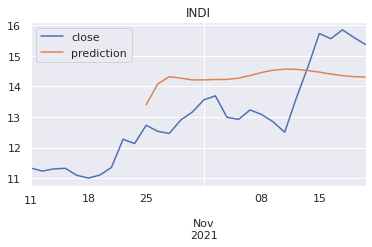

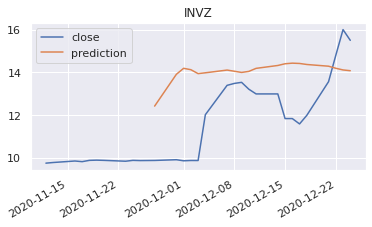

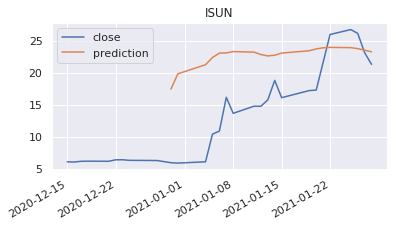

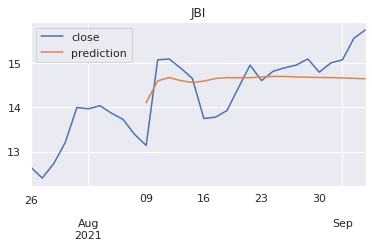

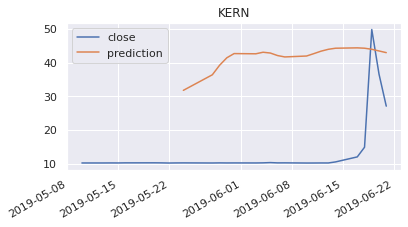

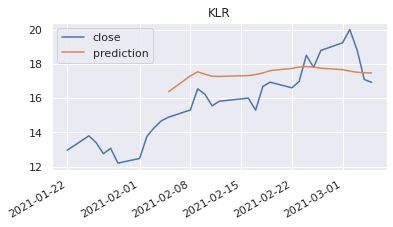

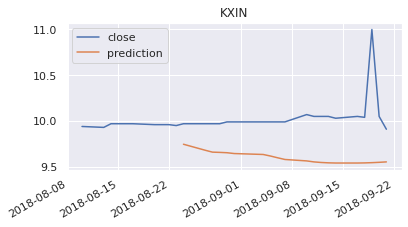

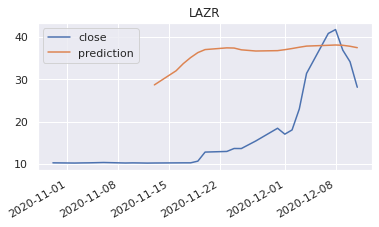

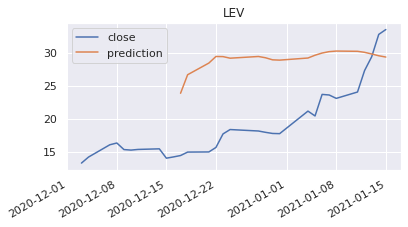

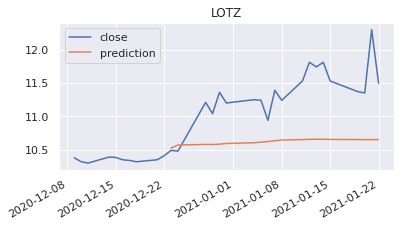

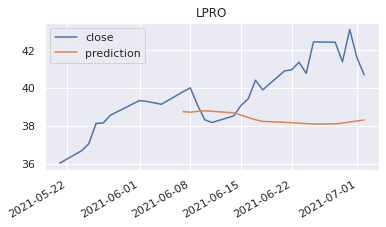

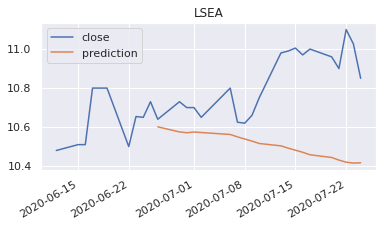

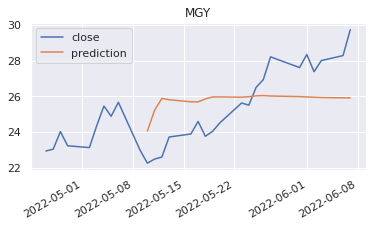

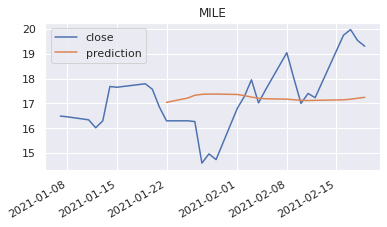

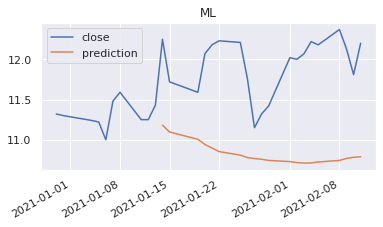

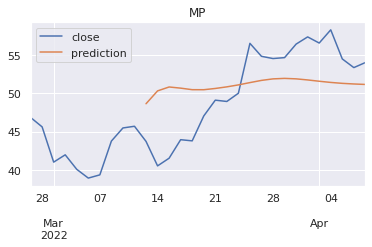

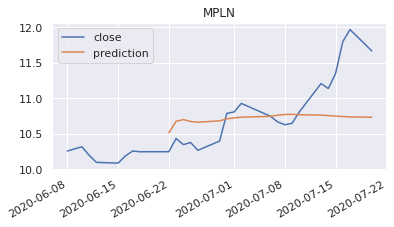

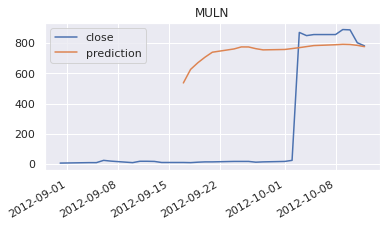

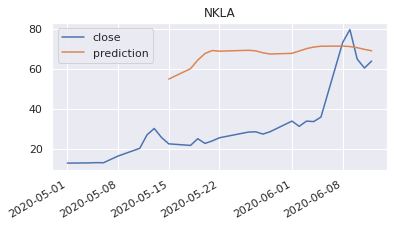

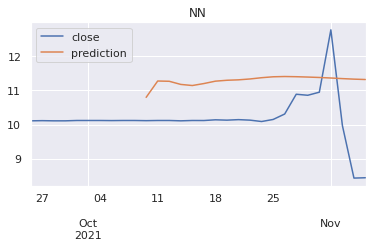

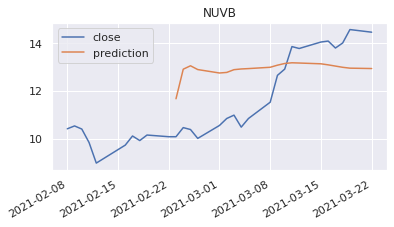

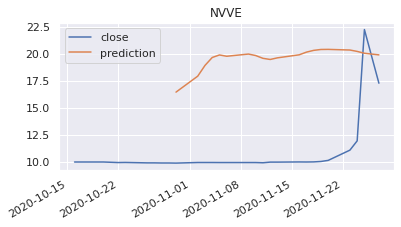

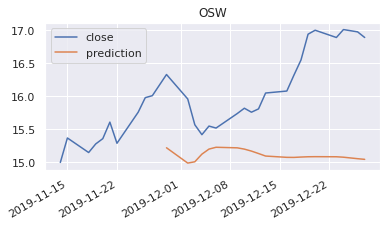

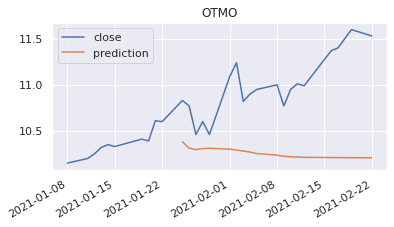

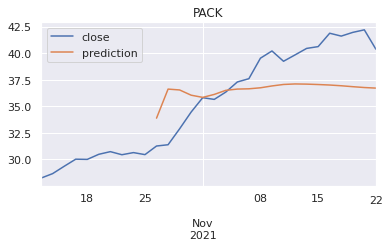

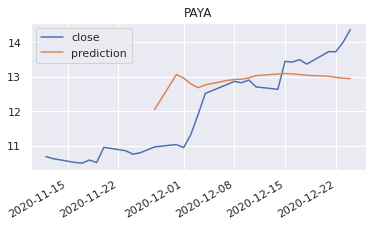

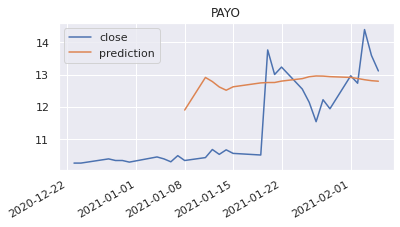

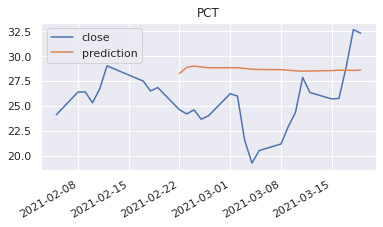

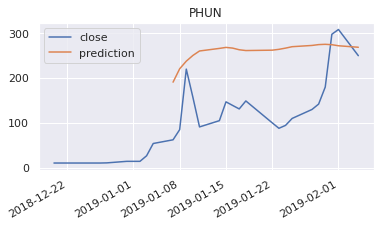

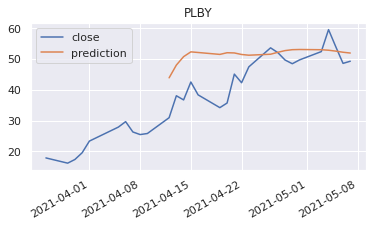

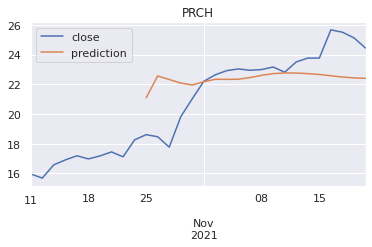

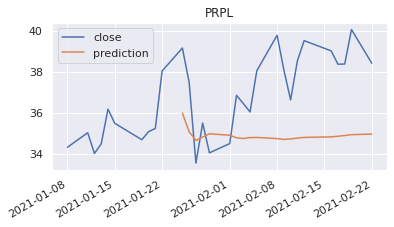

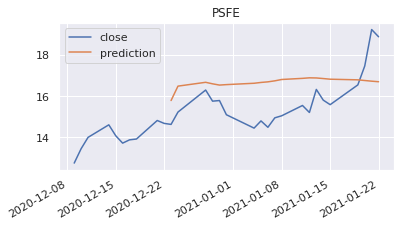

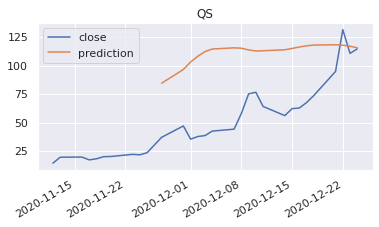

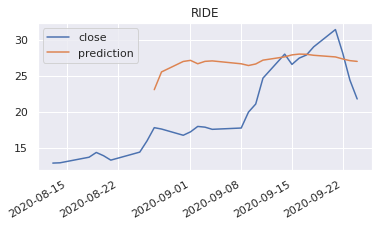

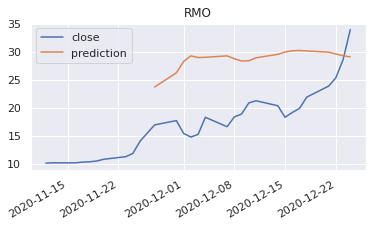

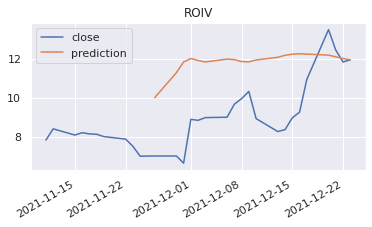

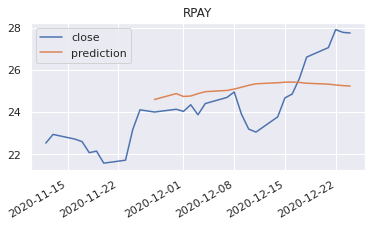

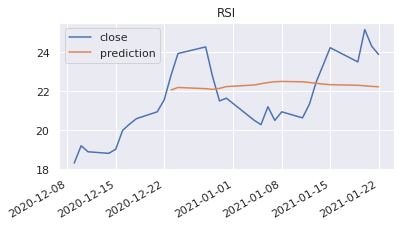

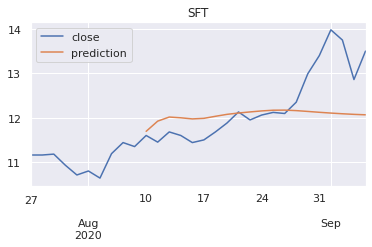

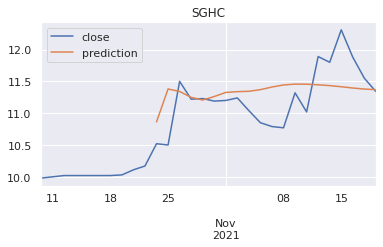

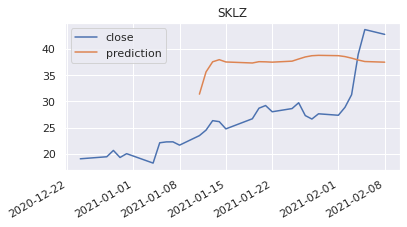

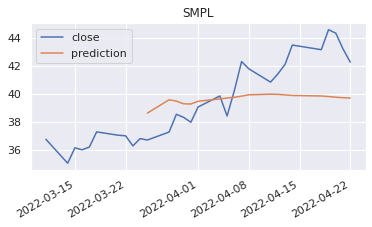

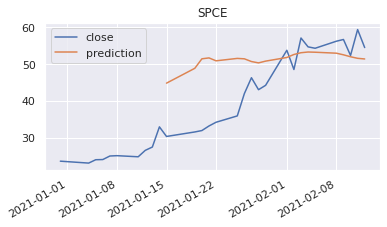

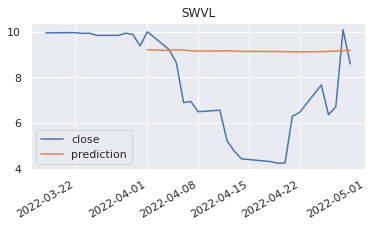

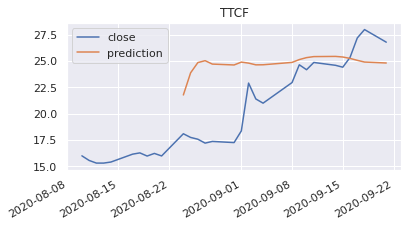

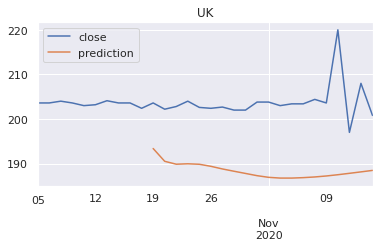

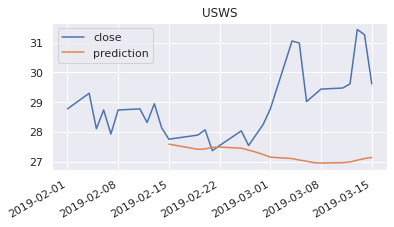

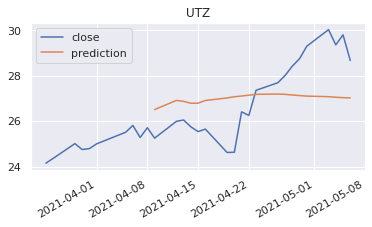

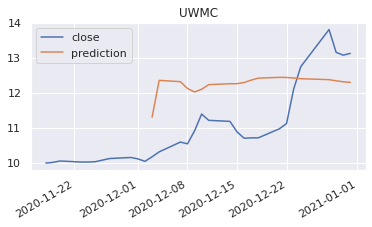

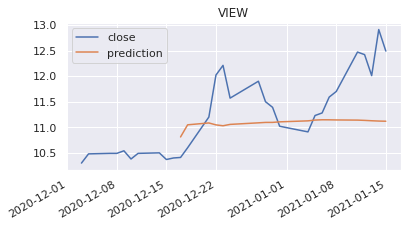

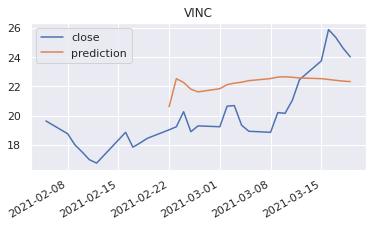

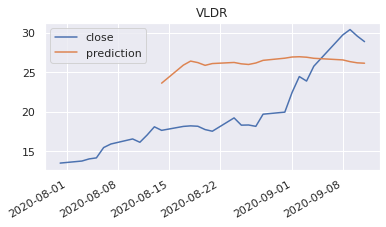

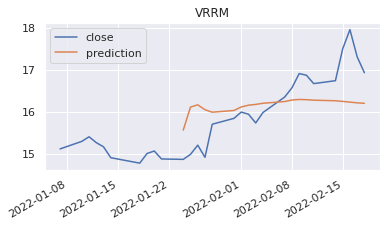

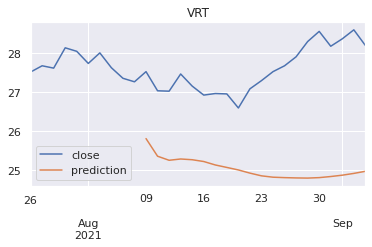

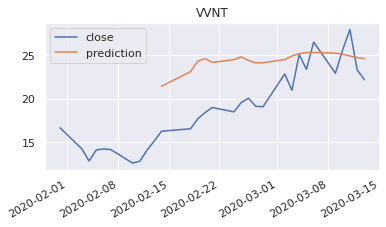

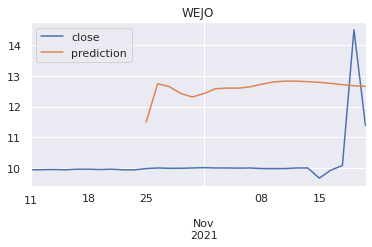

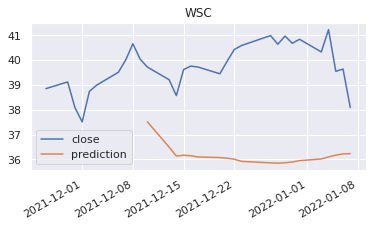

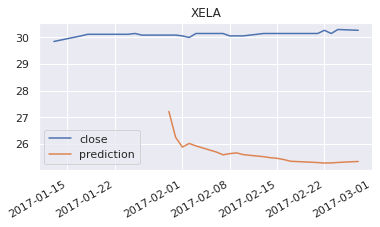

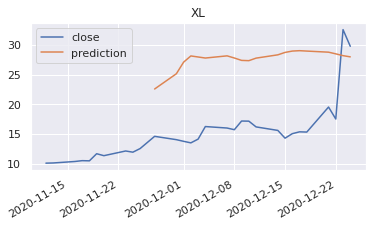

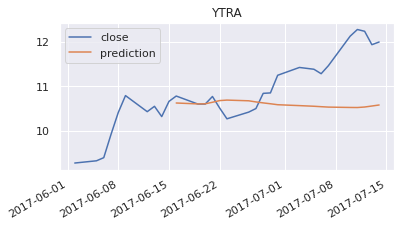

In [159]:
repeat = 20
pd.options.mode.chained_assignment = None
for x in merged_symbols: #['MTTR', 'ENVX', 'CHPT', 'LCID', 'ISPO', 'IRNT', 'IONQ', 'FRGE']:
  if dfs[x]['test_features'] is not None:
    test_features = dfs[x]['test_features'][-repeat:-repeat+1]
    # print(test_features)
    if not test_features.size == 0:
      for i in range(repeat):
        predictions = model.predict(np.array(test_features))
        test_features = np.array([np.append(test_features[0], predictions, axis=0)[1:]])
      result = test_features[0][-repeat:]
      result_df = pd.DataFrame(result, columns=feature_cols)
      # display(ttt[feature_cols])
      result_df[feature_cols] = dfs[x]['scaler'].inverse_transform(result_df)
      # display(ttt[feature_cols])
      # break
      df = dfs[x]['test'].copy()
      df[feature_cols] = dfs[x]['scaler'].inverse_transform(df[feature_cols])
      df['prediction'] = np.nan
      df['prediction'][-repeat:] = result_df['close']
      # display(dfs[x]['train'][['prediction']])
      df[['close', 'prediction']].iloc[-30:].plot(figsize=(6,3), title=x)
      plt.show()
    # _tmp_df = dfs[x]['scaled'].copy()
    # _tmp_df['close'][-predicted_period*cnt:] = np.ravel(predictions.reshape(-1, 1))
    # _tmp_df[feature_cols] = dfs[x]['scaler'].inverse_transform(_tmp_df[feature_cols])
    # _tmp_df.close[:-predicted_period*cnt] = np.full(_tmp_df.index.size - predicted_period*cnt, np.nan)
    # _tmp_df['prediction'] = _tmp_df['close']
    # dfs[x]['train']['prediction'] = _tmp_df['prediction']
    # dfs[x]['train'][['close', 'prediction']].iloc[(-predicted_period-observed_period)*cnt:].plot(figsize=(6,3),title=x)
    # plt.show()

# Conclusion:
Current setup predicts the price of the stock in 20 days bellow actual price.

This result is good as it is safer then predicting a higher than actual price.

We noticed the result seems to be off in some of the cases although almost in all cases the price delta was not that big in this particular examples.

Predicting one day and and feeding it as input to the network gives better results then predicting multiple days in one shot when using LSTM

When we tried to use multiple features with current network setup, the results were worse thus we decided to continue with closign price only